In [ ]:
from typing import NamedTuple

import botorch
import gpytorch
import torch

from utils.training import fit_gp_model
from utils.plots import visualize_gp_belief_and_policy, visualize_progress_and_policy

%load_ext autoreload
%autoreload 2

In [ ]:
class GPData(NamedTuple):
    train_x: torch.Tensor
    train_y: torch.Tensor
    xs: torch.Tensor
    ys: torch.Tensor

In [ ]:
def forrester_1d(x):
    y = -((x + 1) ** 2) * torch.sin(2 * x + 2) / 5 + 1
    return y.squeeze(-1)

In [ ]:
bound = 5
xs = torch.linspace(-bound, bound, bound * 100 + 1).unsqueeze(1)
ys = forrester_1d(xs)

In [ ]:
class GPModel(gpytorch.models.ExactGP, botorch.models.gpytorch.GPyTorchModel):
    num_outputs = 1
    
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel()
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [ ]:
train_x = torch.tensor([[1.], [2.]])
train_y = forrester_1d(train_x)

In [ ]:
data = GPData(train_x, train_y, xs, ys)

In [ ]:
num_queries = 10
for i in range(num_queries):
    print(f"iteration: {i}")
    print(f"incumbent: {train_x[train_y.argmax()]}, obj. func. value: {train_y.max():.4f}")

    data = GPData(train_x, train_y, xs, ys)

    # run training loop to fit the GP
    model, likelihood = fit_gp_model(GPModel, data)

    # compute acquisition scores and get next point
    policy = botorch.acquisition.analytic.ProbabilityOfImprovement(
        model, best_f=train_y.max()
    )
    next_x, acq_score = botorch.optim.optimize_acqf(
        policy,
        bounds=torch.tensor([[-bound * 1.0], [bound * 1.0]]),
        q=1,
        num_restarts=20,
        raw_samples=50
    )
    
    # visualization
    visualize_gp_belief_and_policy(model, likelihood, data, policy, next_x)
    
    # evaluate obj. func. at next_x and update training data
    next_y = forrester_1d(next_x)

    train_x = torch.cat([train_x, next_x])
    train_y = torch.cat([train_y, next_y])

## Exercises

### 4.4.1 - Encouraging exploration with PoI

In [ ]:
num_queries = 10
epsilon_pct = 0.1 
for i in range(num_queries):
    print(f"iteration: {i}")
    print(f"incumbent: {train_x[train_y.argmax()]}, obj. func. value: {train_y.max():.4f}")

    data = GPData(train_x, train_y, xs, ys)

    # run training loop to fit the GP
    model, likelihood = fit_gp_model(GPModel, data)

    # compute acquisition scores and get next point
    policy = botorch.acquisition.analytic.ProbabilityOfImprovement(
        model, best_f=train_y.max() * (1 + epsilon_pct) # add epsilon % to the best observed value
    )
    next_x, acq_score = botorch.optim.optimize_acqf(
        policy,
        bounds=torch.tensor([[-bound * 1.0], [bound * 1.0]]),
        q=1,
        num_restarts=20,
        raw_samples=50
    )
    
    # visualization
    visualize_gp_belief_and_policy(model, likelihood, data, policy, next_x)
    
    # evaluate obj. func. at next_x and update training data
    next_y = forrester_1d(next_x)

    train_x = torch.cat([train_x, next_x])
    train_y = torch.cat([train_y, next_y])

### 4.4.2 - BayesOpt for hyperparameter tuning

In [ ]:
from utils.data_generation import accuracy_func

In [ ]:
# test data
lb, ub = 0, 2
num_queries = 20
bounds = torch.tensor([[lb, lb], [ub, ub]], dtype=torch.float)

xs = torch.linspace(lb, ub, 101)
x1, x2 = torch.meshgrid(xs, xs)
xs = torch.vstack([x1.flatten(), x2.flatten()]).transpose(-1, -2)
ys = accuracy_func(xs)

In [ ]:
class MaternGP(gpytorch.models.ExactGP, botorch.models.gpytorch.GPyTorchModel):
    num_outputs = 1

    def __init__(self, train_x, train_y, likelihood):
        super(MaternGP, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.MaternKernel(
                nu=2.5,
                ard_num_dims=2
                )
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [ ]:
train_x = torch.tensor([[1., 1.]])
train_y = accuracy_func(train_x)

data = GPData(train_x, train_y, xs, ys)

#### PoI

In [ ]:
num_queries = 20
epsilon_pct = 0.1 
for i in range(num_queries):
    print(f"iteration: {i}")
    print(f"incumbent: {train_x[train_y.argmax()]}, obj. func. value: {train_y.max():.4f}")

    data = GPData(train_x, train_y, xs, ys)

    # run training loop to fit the GP
    model, likelihood = fit_gp_model(MaternGP, data)

    # compute acquisition scores and get next point
    policy = botorch.acquisition.analytic.ProbabilityOfImprovement(
        model, best_f=train_y.max() * (1 + epsilon_pct)
    )
    next_x, acq_score = botorch.optim.optimize_acqf(
        policy,
        bounds=bounds,
        q=1,
        num_restarts=40,
        raw_samples=100
    )
    
    # visualization
    visualize_progress_and_policy(data, policy, next_x)
    
    # evaluate obj. func. at next_x and update training data
    next_y = accuracy_func(next_x)

    train_x = torch.cat([train_x, next_x])
    train_y = torch.cat([train_y, next_y])

#### EI

In [ ]:
num_queries = 10
for i in range(num_queries):
    print(f"iteration: {i}")
    print(f"incumbent: {train_x[train_y.argmax()]}, obj. func. value: {train_y.max():.4f}")

    data = GPData(train_x, train_y, xs, ys)

    # run training loop to fit the GP
    model, likelihood = fit_gp_model(MaternGP, data)

    # compute acquisition scores and get next point
    policy = botorch.acquisition.analytic.ExpectedImprovement(
        model, best_f=train_y.max()
    )
    next_x, acq_score = botorch.optim.optimize_acqf(
        policy,
        bounds=bounds,
        q=1,
        num_restarts=40,
        raw_samples=100
    )
    
    # visualization
    visualize_progress_and_policy(data, policy, next_x)
    
    # evaluate obj. func. at next_x and update training data
    next_y = accuracy_func(next_x)

    train_x = torch.cat([train_x, next_x])
    train_y = torch.cat([train_y, next_y])

In [ ]:
num_experiments = 10
num_queries = 10
incumbents = torch.zeros((num_experiments, num_queries, 2))

for trial in range(num_experiments):
    print(f"trial: {trial}")
    torch.manual_seed(trial)

    # generate a random number between 0 and 2
    train_x = bounds[0] + (bounds[1] - bounds[0]) * torch.rand(1, 2)
    train_y = accuracy_func(train_x)

    for i in range(num_queries):
        incumbents[trial, i] = train_y.max()
    
        data = GPData(train_x, train_y, xs, ys)

        # run training loop to fit the GP
        model, likelihood = fit_gp_model(MaternGP, data)

        # compute acquisition scores and get next point
        policy = botorch.acquisition.analytic.ExpectedImprovement(
            model, best_f=train_y.max()
        )
        next_x, acq_score = botorch.optim.optimize_acqf(
            policy,
            bounds=bounds,
            q=1,
            num_restarts=40,
            raw_samples=100
        )
        
        # visualization
        # visualize_progress_and_policy(data, policy, next_x)
        
        # evaluate obj. func. at next_x and update training data
        next_y = accuracy_func(next_x)

        train_x = torch.cat([train_x, next_x])
        train_y = torch.cat([train_y, next_y])

In [55]:
import matplotlib.pyplot as plt

def plot_experiments(res):

    n_queries = res.shape[1]

    def ci(y):
        return 2 * y.std(axis=0) / torch.sqrt(torch.tensor(num_experiments))

    # the first dimension is the experiment number so we take the mean over that
    mean_incumbent = res.mean(axis=0)[:, 0]
    ci_incumbent = ci(res)[:, 0]

    plt.figure(figsize=(7, 3))
    plt.plot(torch.arange(n_queries), mean_incumbent, label="Mean")
    plt.fill_between(
        torch.arange(n_queries),
        mean_incumbent - ci_incumbent,
        mean_incumbent + ci_incumbent,
        alpha=0.2,
        label="CI",
    )
    plt.xlabel("Number of queries made")
    plt.ylabel("SVM estimatd accuracy")
    plt.legend()
    plt.grid(True)
    plt.show();

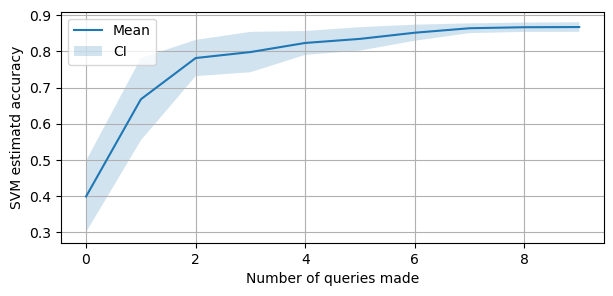

In [56]:
plot_experiments(incumbents)